# Домашнее задание: Реализация логистической регресии

Цель: изучить применение методов оптимизации для решения задачи классификации

Описание задания: необходимо применить полученные знания в теории оптимизации и машинном обучении для реализации логистической регрессии.

Этапы работы:

1. Загрузите данные. Используйте датасет с ирисами. Его можно загрузить непосредственно из библиотеки Sklearn. В данных оставьте только 2 класса: Iris Versicolor, Iris Virginica.\
2. Самостоятельно реализуйте логистическую регрессию, без использования метода LogisticRegression из библиотеки. Можете использовать библиотеки pandas, numpy, math для реализации. Оформите в виде функции.
3. Реализуйте метод градиентного спуска. Обучите логистическую регрессию этим методом. Выберете и посчитайте метрику качества. Метрика должна быть одинакова для всех пунктов домашнего задания. Для упрощения сравнения выберете только одну метрику.
3. Повторите п. 3 для метода скользящего среднего (Root Mean Square Propagation, RMSProp).
4. Повторите п. 3 для ускоренного по Нестерову метода адаптивной оценки моментов (Nesterov–accelerated Adaptive Moment Estimation, Nadam).
5. Сравните значение метрик для реализованных методов оптимизации. Можно оформить в виде таблицы вида |метод|метрика|время работы| (время работы опционально). Напишите вывод.

In [377]:
# для реализации
import pandas as pd
import numpy as np

# для датасета
from sklearn import datasets

# для проверки
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

# для визуализации
import matplotlib.pyplot as plt

# для замера времени выполнения
import time 

## Подготовка данных

In [378]:
# загрузка дата-сета 
iris = datasets.load_iris()

In [379]:
# преобразование в data_frame для удобства работы
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [380]:
# названия классов 
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [381]:
# удалим строки с 'setosa', оставим данные только по 'versicolor', 'virginica'
df = df.drop(df[df.target == 0].index)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
50,7.0,3.2,4.7,1.4,1.0
51,6.4,3.2,4.5,1.5,1.0
52,6.9,3.1,4.9,1.5,1.0
53,5.5,2.3,4.0,1.3,1.0
54,6.5,2.8,4.6,1.5,1.0


In [382]:
# Разделим df на предикторы и таргет
X = df.drop('target', axis=1)
y = df.target

В дальнейшем нам понадобятся обозначения целевых классов в виде (1 и 0). Поэтому классы (1 и 2) в таргете переопределим как (1 и 0)

In [383]:
y[y==2]=0
y

50     1.0
51     1.0
52     1.0
53     1.0
54     1.0
      ... 
145    0.0
146    0.0
147    0.0
148    0.0
149    0.0
Name: target, Length: 100, dtype: float64

Для упрощения не будем делить на тренировочную и тестовую выборки.

Также подготовим таблицу для записи результатов

In [384]:
results = pd.DataFrame(columns=['Name', 'Run time', 'Accuracy', 'LogLoss'])
results

,Name,Run time,Accuracy,LogLoss


## Библиотечная реализация (sklear.LogisticRegression)
Сразу обучим с помощью библитечной реализации, чтобы потом было с чем сравнивать. Для простоты возьмем все параметры по умолчанию.

In [385]:
start = time.time() 

model = LogisticRegression()
model.fit(X, y)

end = time.time()
run_time = end - start
print(run_time)

0.026239871978759766


In [386]:
# веса 
model.coef_, model.intercept_

(array([[ 0.39443136,  0.51327025, -2.93075043, -2.4170433 ]]),
 array([14.43080433]))

In [387]:
# accuracy 
y_true = y
y_pred = model.predict(X)
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.96

In [388]:
logloss = log_loss(y_true, model.predict_proba(X), normalize = False)
logloss

16.62945292543132

In [389]:
# запишем результаты в таблицу
results.loc[len(results.index)] = ['sklear.LogisticRegression', run_time, accuracy, logloss]
results

,Name,Run time,Accuracy,LogLoss
0,sklear.LogisticRegression,0.02624,0.96,16.629453


## Собственная реализация

### Метод градиентного спуска

Уравнение разделяющей гиперплоскости имеет вид:
$$f(w,x) = w_0 + w_1x_1 + w_2x_2 + ... +w_nx_n$$

#### Классификация объектов на (1 и 0).

Функция логистической ошибки, которую требуется минимизировать, имеет вид:
$$L= \sum^{n}_{i=1} \Big(-y_i*log(a_i)-(1-y_i)*log(1-a_i) \Big)$$
где:\
$a_i$ - вероятность принадлежности классу 1\
$(1-a_i)$ - вероятность принадлежности классу 0
$$a_i=\frac{1}{1+exp(-w^T*x_i)}$$


Для расчета градиента нам понадобится производная функции по $w$:
$$ \frac{dL}{dw} = (a-y)*X$$

Формула для коррекции весов:

$$w^{T+1} = w^T-ŋ*∇L(w^T) $$

где ŋ - learning rate (шаг/скорость обучения)

Градиентый спуск - это итеративный метод. Определим условие для его завершения: коррекция весов достигнет некоторого заданного минимального значения либо окончание цикла.

При реализации функции расчета ошибки и градиента будем пользоваться матричной формой.


Так как в уравнении есть свободный вес $w_0$, то необходимо добавить в X еще одну колонку, которая будет его имитировать.

In [390]:
X['x_0'] = 1

In [391]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),x_0
50,7.0,3.2,4.7,1.4,1
51,6.4,3.2,4.5,1.5,1
52,6.9,3.1,4.9,1.5,1
53,5.5,2.3,4.0,1.3,1
54,6.5,2.8,4.6,1.5,1


In [392]:
# функция ошибки
def error(X, w, y):
    """
    Функция для вычисления логистической ошибки.
    На входе: X-признаки, w - веса, y-цели
    На выходе: сумма ошибок
    """
    a = 1/(1+np.exp(-X@w))
    return (-y*np.log(a) - (1-y)*np.log(1-a)).sum()

In [393]:
# функция градиента
def gr_error(X, w, y):
    """
    Функция для вычисления градиента логистической ошибки.
    На входе: X-признаки, w - веса, y-цели
    На выходе: градиент
    """
    a = 1/(1+np.exp(-X@w))
    return (a-y)@X.to_numpy()

##### Установим общие параметры для последующих моделей

In [394]:
# Минимальное значение, на которое должны изменяться веса
eps = 0.001

# Размер шага (learning rate)
learning_rate = 0.001

# Количество итераций
n = 5000

In [395]:
start = time.time() 

# переменная, в которой хранятся веса для следующего шага, зададим начальное значение
next_weights = np.zeros(X.shape[1])

# для хранения ошибок
errors = []

# ну, поехали
for i in range(n):

    # текущие веса
    cur_weights = next_weights

    # обновляем веса
    next_weights = cur_weights - learning_rate * gr_error(X, cur_weights, y)
   
    # записываем ошибки
    errors.append(error(X, cur_weights, y))

    print(f"Итерация: {i}")
    print(f"Текущая точка {cur_weights} | Следующая точка {next_weights}")
    print(f"Ошибка {error(X, cur_weights, y)}")
    print("--------------------------------------------------------")
    
    # выход либо по окончании цикла либо при достижении заданной точности
    if np.linalg.norm(cur_weights - next_weights, ord=2) <= eps:
        break

end = time.time()
run_time = end - start
print(run_time)       

Выходные данные были обрезаны до нескольких последних строк (5000).
Текущая точка [ 2.87126894  2.62209227 -4.14743379 -4.35043842  2.07363296] | Следующая точка [ 2.87172206  2.62266494 -4.14813639 -4.35142842  2.07427875]
Ошибка 13.782971868612567
--------------------------------------------------------
Итерация: 1760
Текущая точка [ 2.87172206  2.62266494 -4.14813639 -4.35142842  2.07427875] | Следующая точка [ 2.87217488  2.62323732 -4.14883857 -4.35241797  2.07492437]
Ошибка 13.780548384842952
--------------------------------------------------------
Итерация: 1761
Текущая точка [ 2.87217488  2.62323732 -4.14883857 -4.35241797  2.07492437] | Следующая точка [ 2.87262742  2.62380941 -4.14954033 -4.35340708  2.07556981]
Ошибка 13.778127189479978
--------------------------------------------------------
Итерация: 1762
Текущая точка [ 2.87262742  2.62380941 -4.14954033 -4.35340708  2.07556981] | Следующая точка [ 2.87307967  2.62438121 -4.15024168 -4.35439574  2.07621509]
Ошибка 13.7757

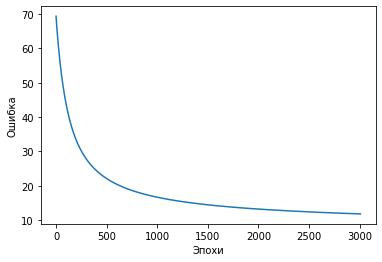

In [396]:
# график - ошибка от эпохи
plt.plot(range(len(errors)), errors)
plt.xlabel('Эпохи')
plt.ylabel('Ошибка')
plt.show()

In [397]:
# полученные значения весов
w = next_weights
w

array([ 3.28330989,  3.17484355, -4.79977603, -5.33541847,  2.78058089])

In [398]:
# вероятности принадлежности классу 1
a = 1/(1+np.exp(-X@w))
a

50     0.997254
51     0.987272
52     0.977144
53     0.881402
54     0.949288
         ...   
145    0.050834
146    0.061018
147    0.120994
148    0.013944
149    0.082719
Length: 100, dtype: float64

In [399]:
# от вероятностей перейдем к классам
y_pred = []
for i in a:
  if i>0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)
y_pred = np.array(y_pred)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [400]:
# так как датсет маленький, то можем посмотреть визульно насколько похожие получились ответы
y_true = np.array(y_true)
y_true

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [401]:
# accuracy для собствтенной модели
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.97

In [402]:
# сравним с библиотечной ошибкой log_loss
logloss = log_loss(y_true, a, normalize = False)
logloss

11.853119139931447

In [403]:
# запишем результаты в таблицу
results.loc[len(results.index)] = ['grad', run_time, accuracy, logloss]
results

,Name,Run time,Accuracy,LogLoss
0,sklear.LogisticRegression,0.026240,0.96,16.629453
1,grad,26.434101,0.97,11.853119


## Оптимизаторы
**Оптимизатор** — это метод достижения лучших результатов, помощь в ускорении обучения. Это алгоритм, используемый для незначительного изменения параметров, таких как веса и скорость обучения, чтобы модель работала правильно и быстро.

### Метод скользящего среднего (Root Mean Square Propagation, RMSProp)

В данном методе вводится нормализация скорости адаптации весов вектора (необходимо для того, чтобы уменьшать скорость обучения для тех весовых коэффициентов, которые имеют большое значение градиента).

$$w^{T+1} = w^T-ŋ\frac{∇L(w^T)}{\sqrt{g}+ϵ} $$

ϵ  - небольшая константа для исключения деления на ноль ($10^{-6}...10^{-8}$)

$$g = αg + (1-α)∇L(w^T)^2$$
$\alpha$ - коэффициент сохранения, обычно $\alpha$ = 0,9

In [404]:
def rmsprop(X, cur_weights, y, g):
  g = alpha*g + (1-alpha)*np.multiply(gr_error(X, cur_weights, y), gr_error(X, cur_weights, y))
  return cur_weights - learning_rate * np.divide(gr_error(X, cur_weights, y), (np.sqrt(g) + 0.0001))

In [405]:
start = time.time() 

# коэф
alpha = 0.9

# начальные значения
next_weights = np.zeros(X.shape[1])
g = np.zeros(X.shape[1])

# для хранения ошибок
errors = []

# ну, поехали
for i in range(n):

    # текущие веса
    cur_weights = next_weights

    # обновляем веса
    g = alpha*g + (1-alpha)*np.multiply(gr_error(X, cur_weights, y), gr_error(X, cur_weights, y))
    next_weights = cur_weights - learning_rate * np.divide(gr_error(X, cur_weights, y), (np.sqrt(g) + 0.0001))
     
    # записываем ошибки
    errors.append(error(X, cur_weights, y))

    print(f"Итерация: {i}")
    print(f"Текущая точка {cur_weights} | Следующая точка {next_weights}")
    print(f"Ошибка {error(X, cur_weights, y)}")
    print("--------------------------------------------------------")
    
    # выход либо по окончании цикла либо при достижении заданной точности
    if np.linalg.norm(cur_weights - next_weights, ord=2) <= eps:
        break   

end = time.time()
run_time = end - start
print(run_time)     

Выходные данные были обрезаны до нескольких последних строк (5000).
Текущая точка [ 2.05230482  2.75161505 -3.72605737 -3.73711655  3.7398857 ] | Следующая точка [ 2.0536783   2.75295435 -3.72694291 -3.73807843  3.7409383 ]
Ошибка 14.233833791598665
--------------------------------------------------------
Итерация: 3751
Текущая точка [ 2.0536783   2.75295435 -3.72694291 -3.73807843  3.7409383 ] | Следующая точка [ 2.05361406  2.75261644 -3.72803054 -3.7391052   3.74187595]
Ошибка 14.2303209452295
--------------------------------------------------------
Итерация: 3752
Текущая точка [ 2.05361406  2.75261644 -3.72803054 -3.7391052   3.74187595] | Следующая точка [ 2.05498754  2.75395574 -3.72891597 -3.74006707  3.74292855]
Ошибка 14.226830914644035
--------------------------------------------------------
Итерация: 3753
Текущая точка [ 2.05498754  2.75395574 -3.72891597 -3.74006707  3.74292855] | Следующая точка [ 2.05492329  2.75361779 -3.73000368 -3.74109385  3.7438662 ]
Ошибка 14.223322

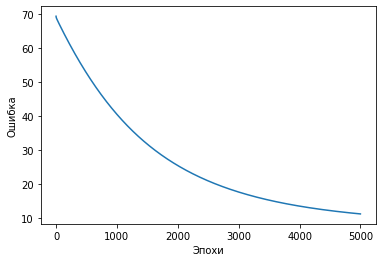

In [406]:
# график - ошибка от эпохи
plt.plot(range(len(errors)), errors)
plt.xlabel('Эпохи')
plt.ylabel('Ошибка')
plt.show()

In [407]:
# полученные значения весов
w = next_weights
w

array([ 2.86600536,  3.37102362, -4.94766683, -4.98000959,  4.98406302])

In [408]:
# ошибка
errors[-1]

11.131797109469145

In [409]:
# вероятности принадлежности классу 1
a = 1/(1+np.exp(-X@w))
a

50     0.996343
51     0.987621
52     0.970576
53     0.903416
54     0.943889
         ...   
145    0.053024
146    0.061060
147    0.123281
148    0.018768
149    0.100602
Length: 100, dtype: float64

In [410]:
# от вероятностей перейдем к классам
y_pred = []
for i in a:
  if i>0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)
y_pred = np.array(y_pred)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [411]:
# так как датсет малнький, то можем посмотреть визульно насколько похожие получились ответы
y_true = np.array(y_true)
y_true

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [412]:
# accuracy для собствтенной модели
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.97

In [413]:
logloss = log_loss(y_true, a, normalize = False)
logloss

11.130105867049778

In [414]:
# запишем результаты в таблицу
results.loc[len(results.index)] = ['rmsprop', run_time, accuracy, logloss]
results

,Name,Run time,Accuracy,LogLoss
0,sklear.LogisticRegression,0.026240,0.96,16.629453
1,grad,26.434101,0.97,11.853119
2,rmsprop,56.944667,0.97,11.130106


### Ускоренный по Нестерову метод адаптивной оценки моментов (Nesterov–accelerated Adaptive Moment Estimation, Nadam)



$$w^{T+1} = w^T- v^T $$

$$v^T = αv^{T-1} + ŋ∇L(w^T)$$

In [415]:
start = time.time() 

# коэф
alpha = 0.9

# начальные значения
next_weights = np.zeros(X.shape[1])
v = np.zeros(X.shape[1])

# для хранения ошибок
errors = []

# ну, поехали
for i in range(n):

    # текущие веса
    cur_weights = next_weights

    # обновляем веса
    v = alpha * v + learning_rate * gr_error(X, cur_weights-alpha*v, y)
    next_weights = cur_weights - v
   
    # записываем ошибки
    errors.append(error(X, cur_weights, y))

    print(f"Итерация: {i}")
    print(f"Текущая точка {cur_weights} | Следующая точка {next_weights}")
    print(f"Ошибка {error(X, cur_weights, y)}")
    print("--------------------------------------------------------")
    
    # выход либо по окончании цикла либо при достижении заданной точности
    if np.linalg.norm(cur_weights - next_weights, ord=2) <= eps:
        break  

end = time.time()
run_time = end - start
print(run_time)

Выходные данные были обрезаны до нескольких последних строк (5000).
Текущая точка [  4.06515064   5.14743369  -6.92293645 -10.37264721  11.28234468] | Следующая точка [  4.0650292    5.14749742  -6.9229867  -10.37309963  11.28394825]
Ошибка 7.60514850146129
--------------------------------------------------------
Итерация: 3751
Текущая точка [  4.0650292    5.14749742  -6.9229867  -10.37309963  11.28394825] | Следующая точка [  4.06490774   5.1475611   -6.9230369  -10.3735519   11.28555157]
Ошибка 7.604869157698895
--------------------------------------------------------
Итерация: 3752
Текущая точка [  4.06490774   5.1475611   -6.9230369  -10.3735519   11.28555157] | Следующая точка [  4.06478626   5.14762472  -6.92308705 -10.37400404  11.28715464]
Ошибка 7.604589907005816
--------------------------------------------------------
Итерация: 3753
Текущая точка [  4.06478626   5.14762472  -6.92308705 -10.37400404  11.28715464] | Следующая точка [  4.06466476   5.1476883   -6.92313714 -10.3

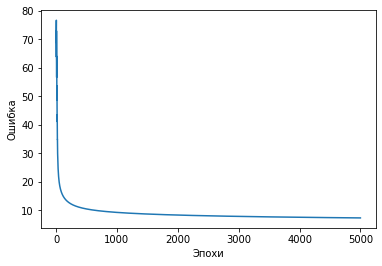

In [416]:
# график - ошибка от эпохи
plt.plot(range(len(errors)), errors)
plt.xlabel('Эпохи')
plt.ylabel('Ошибка')
plt.show()

In [417]:
# полученные значения весов
w = next_weights
w

array([  3.90756288,   5.19723684,  -6.958079  , -10.84854727,
        13.11691729])

In [418]:
#ошибка
errors[-1]

7.3151764175615295

In [419]:
# вероятности принадлежности классу 1
a = 1/(1+np.exp(-X@w))
a

50     0.999900
51     0.999233
52     0.997050
53     0.990308
54     0.991743
         ...   
145    0.001938
146    0.009240
147    0.022504
148    0.000547
149    0.037315
Length: 100, dtype: float64

In [420]:
# от вероятностей перейдем к классам
y_pred = []
for i in a:
  if i>0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)
y_pred = np.array(y_pred)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [421]:
# так как датсет маленький, то можем посмотреть визульно насколько похожие получились ответы
y_true = np.array(y_true)
y_true

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [422]:
# accuracy для собсвтенной модели
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.97

In [423]:
logloss = log_loss(y_true, a, normalize = False)
logloss

7.314982819781209

In [424]:
# запишем результаты в таблицу
results.loc[len(results.index)] = ['nadam', run_time, accuracy, logloss]
results

,Name,Run time,Accuracy,LogLoss
0,sklear.LogisticRegression,0.026240,0.96,16.629453
1,grad,26.434101,0.97,11.853119
2,rmsprop,56.944667,0.97,11.130106
3,nadam,43.055295,0.97,7.314983


## Вывод
Реализованы методы оптимизации в задаче бинарной классификации:
- градиентый спуск
- метод скользящего среднего (Root Mean Square Propagation, RMSProp)
- ускоренный по Нестерову метод адаптивной оценки моментов (Nesterov–accelerated Adaptive Moment Estimation, Nadam).

Рассчитаная ошибка log_loss совпдает  с библиотечной реализацией.
Точность accuracy и ошибка LogLoss у реализованных моделей получилась лучше, чем у библиотечной реализации с дефолтными параметрами.


С оптимизаторами accuracy осталась на том же уровне, но немного удалось уменьшить ошибку LogLoss. При этом времени на обработку ушло гораздо больше. В случае простого градиентного спуска цикл завершился раньше, достигнув заданной точности коррекции весов. В остальных случаях цикл прошел полностью. При этом исходные параметры для всех были одинаковы. Возможно если для оптимизаторов задать другие, то отработали бы быстрее.
